<a href="https://colab.research.google.com/github/nirajandata/phenix/blob/main/phenix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Written in 2023/05/12
import torch
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
daf=pd.read_csv("GOOGL.csv")
n=len(daf)
tensor = torch.tensor((), dtype=torch.float64)
device="cuda" if torch.cuda.is_available() else "cpu"


In [ ]:
# todo: shifting closing value data to different date to make the data work mostly on recent data
daf.head()



,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-02-01,13.378378,13.408659,13.270771,13.338839,13.338839,89941968
1,2010-02-02,13.387387,13.387387,13.203453,13.291291,13.291291,163684152
2,2010-02-03,13.229980,13.566066,13.218969,13.534034,13.534034,119844036
3,2010-02-04,13.438438,13.463463,13.152152,13.182683,13.182683,134972892
4,2010-02-05,13.223223,13.350851,13.074575,13.295546,13.295546,126113760


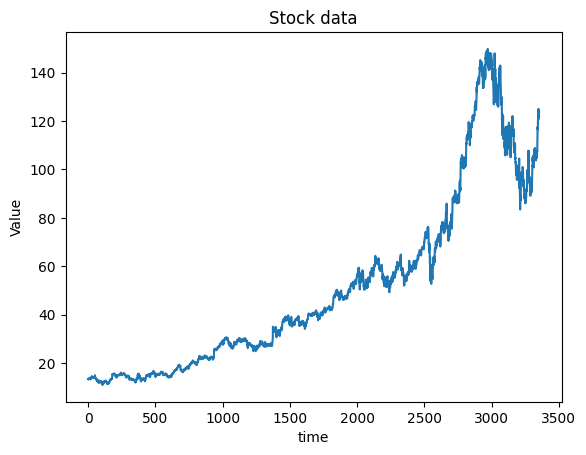

In [ ]:
plt.title("Stock data")
plt.xlabel("time")
plt.ylabel("Value")
plt.plot(daf["Close"])

In [ ]:
def normalize(df):
  mx=np.max(df)
  a=[]
#  a=torch.zeros(n)

  for i in range(n):
    a.append(df[i]/mx)
  return a


def recurrence_level(df,depth):
  X=[]
  Y=[]
  for i in range(len(df)-depth):
    change=i+depth
    x=df[i:change]
    y=df[i+1:change+1]
    X.append(x)
    Y.append(y)

  return torch.tensor(X), torch.tensor(Y)


In [ ]:
daf.head()

df= daf[["Close"]].values.astype('float32')

norm=np.linalg.norm(df)
df=df/np.linalg.norm(df)

sz_part=int(.6*n)
train_data,test_data=df[:sz_part],df[sz_part:]


In [ ]:
print(df)

[[0.00367632]
 [0.00366322]
 [0.00373012]
 ...
 [0.03403236]
 [0.0343438 ]
 [0.03408473]]


In [ ]:
class Model(torch.nn.Module):
  def __init__(self,inp_dim, sz_hidden, num_class, sz_layers):

    super(Model,self).__init__()

    self.sz_hidden=sz_hidden
    self.sz_layers=sz_layers
    self.Fr=torch.nn.LSTM(inp_dim,sz_hidden,sz_layers,batch_first=True)
    self.Last=torch.nn.Linear(sz_hidden,num_class)


  def forward(self,X):

    hidden_state=torch.zeros(self.sz_layers, X.size(0), self.sz_hidden)
    node_st=torch.zeros(self.sz_layers, X.size(0), self.sz_hidden)

    prediction, _=self.Fr(X, (hidden_state, node_st))
    prediction =self.Last(prediction[:, -1, :])

    return prediction


In [ ]:
depth=4

x_train,y_train=recurrence_level(train_data,depth)
x_test,y_test=recurrence_level(test_data,depth)

print(x_train.shape)
data_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train,y_train), shuffle=True, batch_size=4)


torch.Size([2009, 4, 1])


In [ ]:

print(train_data)

0        13.338839
1        13.291291
2        13.534034
3        13.182683
4        13.295546
           ...    
3014    133.307495
3015    130.351501
3016    130.804001
3017    126.934998
3018    129.233002
Name: Close, Length: 3019, dtype: float64


In [ ]:
#hyperparams
inp_dim=1
sz_hidden=30
num_class=1
sz_layers=2
loss_function=torch.nn.MSELoss()
epoch =100
lr=0.003
optim=torch.optim.Adam(model.parameters(), lr)
model=Model(inp_dim, sz_hidden, num_class, sz_layers)


for i in range(epoch):
  model.train()
  for x,y in data_loader:

    y_hat=model(x)
    loss=loss_function(y_hat,y)
    optim.zero_grad
    loss.backward()
    optim.step()

  if(epoch&16):
    model.eval()
    with torch.no_grad():
      Y_hat=model(x_test)
      test_loss=loss_function(Y_hat,y_test)
      print(f"testing loss: {test_loss} \n")
  print(f"Step: {i}: training loss: {loss} \n")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([4, 4, 1])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 4, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Step: 0: training loss: 0.007452796678990126 

Step: 1: training loss: 0.006271048448979855 

Step: 2: training loss: 0.006845118012279272 

Step: 3: training loss: 0.00676932604983449 

Step: 4: training loss: 0.00741846626624465 

Step: 5: training loss: 0.00685947434976697 

Step: 6: training loss: 0.0062004681676626205 

Step: 7: training loss: 0.006874685641378164 

Step: 8: training loss: 0.007004375569522381 

Step: 9: training loss: 0.007405866403132677 

Step: 10: training loss: 0.00787576474249363 

Step: 11: training loss: 0.007246930152177811 

Step: 12: training loss: 0.007170960307121277 

Step: 13: training loss: 0.00660921074450016 

Step: 14: training loss: 0.006809074431657791 

Step: 15: training loss: 0.006801784969866276 

Step: 16: training loss: 0.006603817455470562 

Step: 17: training loss: 0.006276674568653107 

Step: 18: training loss: 0.006866966374218464 

Step: 19: training loss: 0.00779058039188385 

Step: 20: training loss: 0.0062991296872496605 

Step: 

In [ ]:
#add risk factor
r=0.9



[-0.07518331] [-0.07518155]


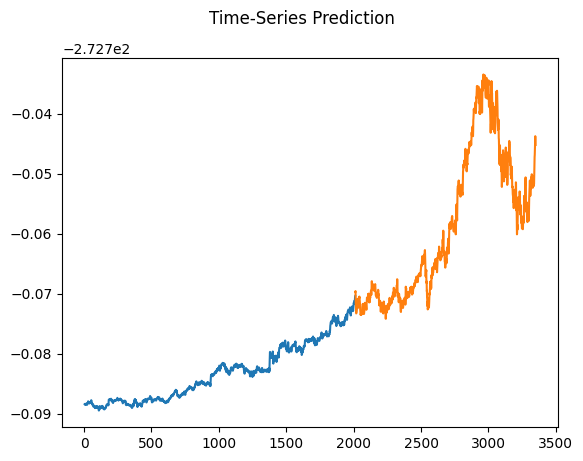

In [ ]:
model.eval()
predict = model(x_train)

predict = predict.data.numpy()
prev = np.ones_like(df) * np.nan
after=np.copy(prev)


#data_predict/=np.linalg.norm(df)

#ax.invert_yaxis()

y_data = y_data*norm
prev[depth:len(predict)+depth]=predict*norm
valid=model(x_test)
valid=valid.data.numpy()
after[len(predict)+depth:len(predict)+len(valid)+depth]=valid*norm

print(predict[0],predict[1000])

#predict=np.flip(predict)
plt.plot(prev)
plt.plot(after)
plt.suptitle('Time-Series Prediction')
plt.show()



In [ ]:
plot.plot(after)

In [ ]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('model_scripted.pt') # Save

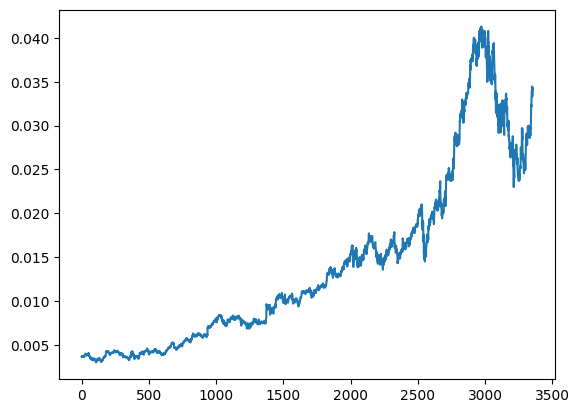

In [ ]:
plt.plot(df)